# Modeling Health Care Data App

* This notebook uses SMOTE and cross-validation.

In [5]:
import sys
import os

from scipy import stats
from datetime import datetime, date
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
import xgboost as xgb


%matplotlib inline
plt.style.use("fivethirtyeight")
sns.set_context("notebook")

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_predict,cross_validate
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Import DF

url = 'https://raw.githubusercontent.com/davidrkearney/colab-notebooks/main/datasets/strokes_training.csv'
df = pd.read_csv(url, error_bad_lines=False)
df.info()

## Data Prep

df = df.drop(columns = ['id'])

# Label Encoding
for f in df.columns:
    if df[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(df[f].values))
        df[f] = lbl.transform(list(df[f].values))

pct_list = []
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    if round(pct_missing*100) >0:
        pct_list.append([col, round(pct_missing*100)])
    print('{} - {}%'.format(col, round(pct_missing*100)))

df = df.fillna(df.mean())

df=df.dropna()
df.info()

Features = ['age','heart_disease','ever_married']
x = df[Features]
y = df["stroke"]

# Train Test split
X_train, X_test,y_train,y_test = train_test_split(x,y, test_size=0.2, random_state=2)


#### Data Preprocessing

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate
import xgboost as xgb



clf = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=9,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    missing=-999,
    random_state=2021,
    tree_method='auto'
#    tree_method='hist'
#    tree_method='gpu_hist'
)

kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

param_grid = { 
    'colsample_bytree':[.75,1],
    'learning_rate':[0.01,0.05,0.1,0.3,0.5],
    'max_depth':[1,2,3,5],
    'subsample':[.75,1],
    'n_estimators': list(range(50, 400, 50))
}

grid_search = GridSearchCV(estimator=clf, scoring='roc_auc', param_grid=param_grid, n_jobs=-1, cv=kfold)

%%time
grid_result = grid_search.fit(X_train, y_train)

print(f'Best: {grid_result.best_score_} using {grid_result.best_params_}','\n')



#Set our final hyperparameters to the tuned values
xgbcl = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
         gamma=0.0, max_delta_step=0.0, min_child_weight=1.0,
         missing=None, n_jobs=-1, objective='binary:logistic', random_state=42, reg_alpha=0.0,
         reg_lambda=1.0, scale_pos_weight=1.0, tree_method='auto',
         colsample_bytree = grid_result.best_params_['colsample_bytree'], 
         learning_rate = grid_result.best_params_['learning_rate'], 
         max_depth = grid_result.best_params_['max_depth'], 
         subsample = grid_result.best_params_['subsample'], 
         n_estimators = grid_result.best_params_['n_estimators'])

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#refit the model on k-folds to get stable avg error metrics
scores = cross_validate(estimator=xgbcl, X=X_train, y=y_train, cv=kfold, n_jobs=-1, 
                        scoring=['accuracy', 'roc_auc', 'precision', 'recall', 'f1'])

print('Training 5-fold Cross Validation Results:\n')
print('AUC: ', scores['test_roc_auc'].mean())
print('Accuracy: ', scores['test_accuracy'].mean())
print('Precision: ', scores['test_precision'].mean())
print('Recall: ', scores['test_recall'].mean())
print('F1: ', scores['test_f1'].mean(), '\n')



import sklearn.metrics as metrics

#Fit the final model
xgbcl.fit(X_train, y_train)

#Generate predictions against our training and test data
pred_train = xgbcl.predict(X_train)
proba_train = xgbcl.predict_proba(X_train)
pred_test = xgbcl.predict(X_test)
proba_test = xgbcl.predict_proba(X_test)

# Print model report
print("Classification report (Test): \n")
print(metrics.classification_report(y_test, pred_test))
print("Confusion matrix (Test): \n")
print(metrics.confusion_matrix(y_test, pred_test)/len(y_test))

print ('\nTrain Accuracy:', metrics.accuracy_score(y_train, pred_train))
print ('Test Accuracy:', metrics.accuracy_score(y_test, pred_test))

print ('\nTrain AUC:', metrics.roc_auc_score(y_train, proba_train[:,1]))
print ('Test AUC:', metrics.roc_auc_score(y_test, proba_test[:,1]))

# calculate the fpr and tpr for all thresholds of the classification
train_fpr, train_tpr, train_threshold = metrics.roc_curve(y_train, proba_train[:,1])
test_fpr, test_tpr, test_threshold = metrics.roc_curve(y_test, proba_test[:,1])

train_roc_auc = metrics.auc(train_fpr, train_tpr)
test_roc_auc = metrics.auc(test_fpr, test_tpr)

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=[7,5])
plt.title('Receiver Operating Characteristic')
plt.plot(train_fpr, train_tpr, 'b', label = 'Train AUC = %0.2f' % train_roc_auc)
plt.plot(test_fpr, test_tpr, 'g', label = 'Test AUC = %0.2f' % test_roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# plot feature importance
xgb.plot_importance(xgbcl, importance_type='gain');





pickle.dump(xgbcl, open('stroke_xgboost_model.pkl', 'wb'))
pickle.dump(scaler, open('scaler.pkl', 'wb'))


model = pickle.load(open('stroke_xgboost_model.pkl', 'rb'))
print(model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
              colsample_bynode=1, colsample_bytree=0.75, gamma=0.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0.0, max_depth=1,
              min_child_weight=1.0, missing=None, monotone_constraints='()',
              n_estimators=200, n_jobs=-1, num_parallel_tree=1, random_state=42,
              reg_alpha=0.0, reg_lambda=1.0, scale_pos_weight=1.0,
              subsample=0.75, tree_method='auto', validate_parameters=1,
              verbosity=None)


# Random Forest Classifier

# Feature and Target Selection

In [168]:
# Select feature and target variables:
X = df.drop(['stroke'], axis=1)
y = df[['stroke']]

In [169]:
#One-hot encode the data using pandas get_dummies
X = pd.get_dummies(X)

In [170]:
#rus = RandomUnderSampler(random_state=0, replacement=True)
#X_resampled, y_resampled = rus.fit_resample(X, y)
#print(np.vstack(np.unique([tuple(row) for row in X_resampled], axis=0)).shape)

In [171]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns

sm = SMOTE(random_state=1)
X_train_SMOTE, y_train_SMOTE = sm.fit_sample(X_train, y_train)

In [172]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics


model = RandomForestClassifier(n_estimators=100, bootstrap=True,
                               max_features='sqrt', n_jobs=3, verbose=1, class_weight="balanced")

model.fit(X_train_SMOTE, y_train_SMOTE)

y_pred = model.predict(X_test)

<ipython-input-172-58a1a4a55e81>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_SMOTE, y_train_SMOTE)
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.9s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    2.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.1s finished


In [173]:
from sklearn.metrics import roc_auc_score

# Calculate roc auc
roc_value = roc_auc_score(y_test, y_pred)
roc_value

0.5381645695594856

In [174]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.9531490015360983
Precision: 0.05491990846681922
Recall: 0.1085972850678733


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.2s finished


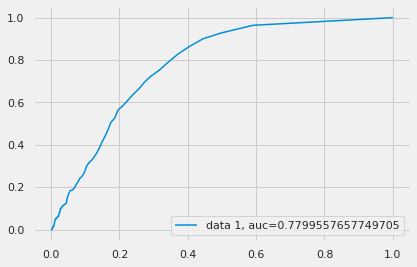

In [175]:
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

Text(0, 0.5, 'Precision')

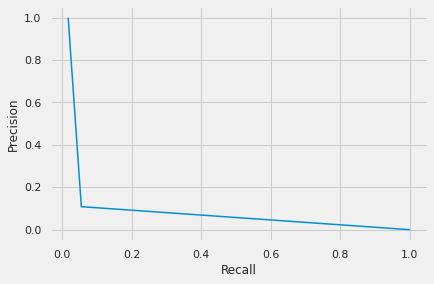

In [176]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from inspect import signature

precision, recall, _ = precision_recall_curve(y_test, y_pred)

plt.plot(precision,recall)
plt.xlabel('Recall')
plt.ylabel('Precision')

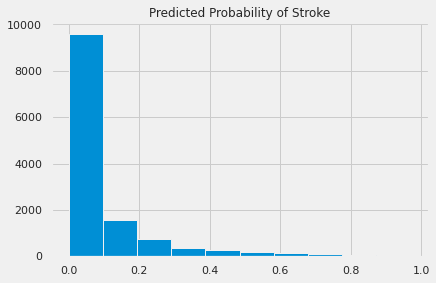

In [177]:
# Import numpy and matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Construct the histogram with a flattened 3d array and a range of bins
plt.hist(y_pred_proba.ravel())

# Add a title to the plot
plt.title('Predicted Probability of Stroke')

# Show the plot
plt.show()

In [178]:
len(y_pred_proba)

13020

In [179]:
y_pred

array([1, 0, 0, ..., 0, 0, 1])

 # Get feature importances for interpretability

In [180]:
# Get numerical feature importances
importances = list(model.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(X, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the features and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: age                  Importance: 0.44
Variable: avg_glucose_level    Importance: 0.19
Variable: bmi                  Importance: 0.15
Variable: work_type            Importance: 0.06
Variable: smoking_status       Importance: 0.05
Variable: gender               Importance: 0.03
Variable: Residence_type       Importance: 0.03
Variable: hypertension         Importance: 0.02
Variable: ever_married         Importance: 0.02
Variable: heart_disease        Importance: 0.01


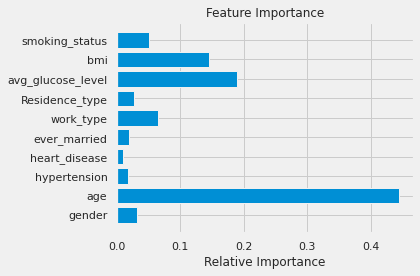

In [181]:
plt.figure(1)
plt.title('Feature Importance')
x_values = list(range(len(importances)))
plt.barh(x_values,  importances, align='center')
plt.yticks(x_values, X)
plt.xlabel('Relative Importance')
plt.tight_layout() 

In [182]:
import pandas as pd
feature_importances = pd.DataFrame(model.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

In [183]:
importances

[0.030891482100094805,
 0.4448331026265109,
 0.017695413344245573,
 0.009520184938617332,
 0.01937533663501595,
 0.06499114062861666,
 0.026702090192497516,
 0.18974364950033454,
 0.14563102038830425,
 0.050616579645762515]

# Confusion Matrix


In [184]:
from sklearn.metrics import confusion_matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[12386,   413],
       [  197,    24]])

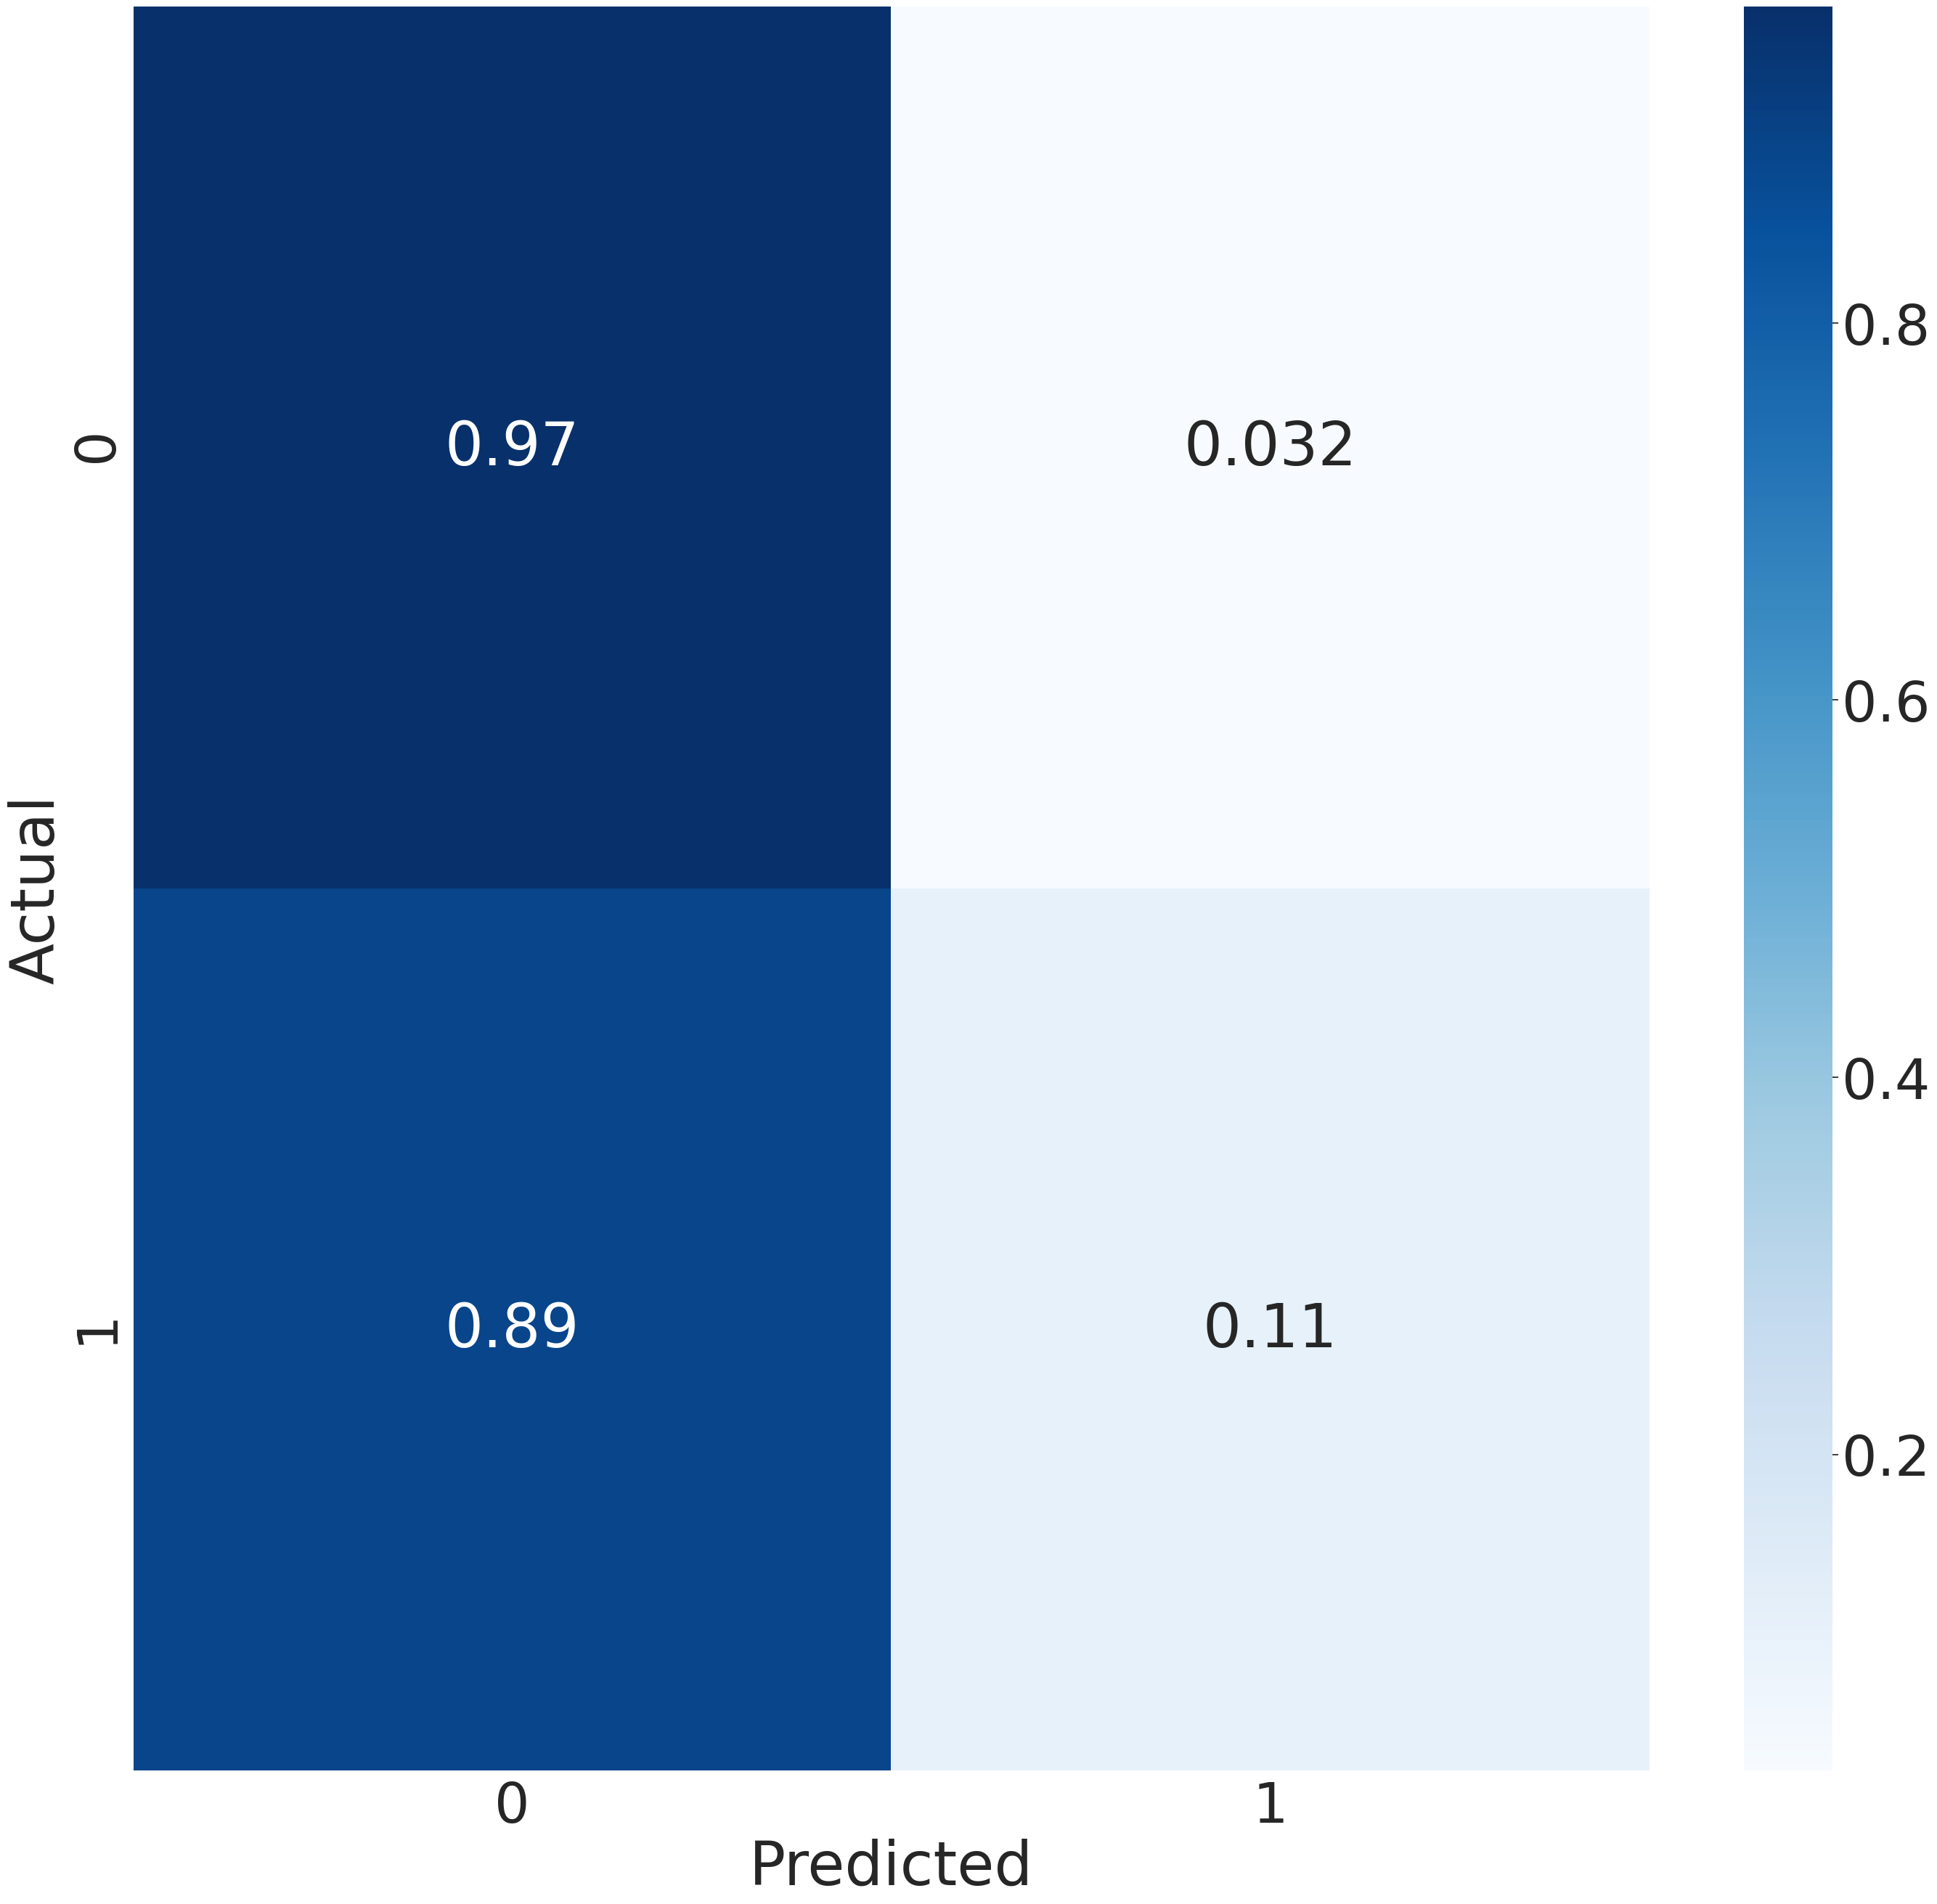

In [185]:
sns.set(font_scale=5.0)
conf_mat = confusion_matrix(y_test, y_pred)
cm_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(30,30), dpi = 100)
sns.heatmap(cm_normalized, annot=True, cmap="Blues")
sns.set(font_scale=1)
plt.ylabel('Actual')
plt.xlabel('Predicted')
#fig.savefig('cm_augmented.png', dpi=fig.dpi, transparent=True)
plt.show()

In [186]:
cm_normalized

array([[0.96773185, 0.03226815],
       [0.89140271, 0.10859729]])

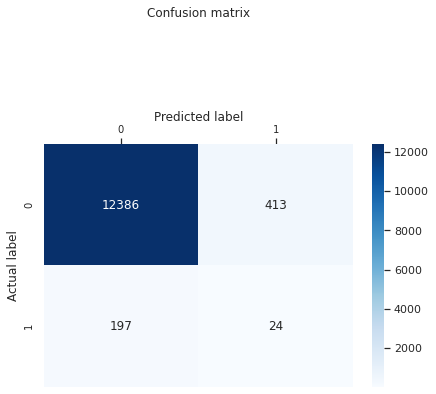

In [187]:
fig, ax = plt.subplots()
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="Blues" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.5)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = True, labeltop=True)

In [188]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics


model = RandomForestClassifier(n_estimators=100, bootstrap=True,
                               max_features='sqrt', n_jobs=3, verbose=1, class_weight="balanced")

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

<ipython-input-188-533b6710c3e5>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.3s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.1s finished


In [189]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics


model = RandomForestClassifier(n_estimators=100, bootstrap=True,
                               max_features='sqrt', n_jobs=3, verbose=1, class_weight="balanced")

model.fit(X_train_SMOTE, y_train_SMOTE)

y_pred = model.predict(X_test)

<ipython-input-189-58a1a4a55e81>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train_SMOTE, y_train_SMOTE)
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.8s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    1.9s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.1s finished


In [190]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

Accuracy: 0.9541474654377881
Precision: 0.05660377358490566
Recall: 0.1085972850678733


In [191]:
y_pred = model.predict_proba(X_test)[:,1]
train_proba = pd.DataFrame({'predicted_probability': y_pred})
train_proba.info()

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13020 entries, 0 to 13019
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   predicted_probability  13020 non-null  float64
dtypes: float64(1)
memory usage: 101.8 KB


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.2s finished


In [192]:
##check whether y_train indexes are the same as X_train indexes 
same_index = y_test.index == X_test.index
same_index.all()

True

In [193]:
## get them into the same pandas frame
table = pd.concat([y_test.reset_index(drop=True), train_proba.reset_index(drop=True)], axis=1)
table

,stroke,predicted_probability
0,0,0.63
1,0,0.25
2,0,0.00
3,0,0.00
4,0,0.00
...,...,...
13015,0,0.00
13016,0,0.00
13017,0,0.00
13018,0,0.00


In [194]:
table.stroke.value_counts()

0    12799
1      221
Name: stroke, dtype: int64

In [195]:
table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13020 entries, 0 to 13019
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   stroke                 13020 non-null  int64  
 1   predicted_probability  13020 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 203.6 KB


In [196]:
table.to_csv('../processed_csvs/healthcare_table.csv')

# Cross-Validation Precision

In [197]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [198]:
#cross validation predictions for test set
y_test_pred = cross_val_predict(forest_clf, X_test, y_test, cv=5)

print("Accuracy:",metrics.accuracy_score(y_test, y_test_pred))
print("Precision:",metrics.precision_score(y_test, y_test_pred))
print("Recall:",metrics.recall_score(y_test, y_test_pred))

/home/david/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:862: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/david/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:862: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/david/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:862: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/david/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:862: DataConversionW

Accuracy: 0.9827188940092166
Precision: 0.0
Recall: 0.0


In [199]:
#cross validation predictions for full dataset
y_pred = cross_val_predict(forest_clf, X, y, cv=5)

/home/david/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:862: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/david/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:862: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/david/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:862: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/home/david/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:862: DataConversionW

In [200]:
print("Accuracy:",metrics.accuracy_score(y, y_pred))
print("Precision:",metrics.precision_score(y, y_pred))
print("Recall:",metrics.recall_score(y, y_pred))

Accuracy: 0.9817741935483871
Precision: 0.0
Recall: 0.0


In [201]:
test_proba = pd.DataFrame({'predicted_probability': y_pred})
test_proba.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   predicted_probability  43400 non-null  int64
dtypes: int64(1)
memory usage: 339.2 KB


In [202]:
##check whether y_test indexes are the same as X_test indexes 
same_index = y.index == X.index
same_index.all()

True

In [203]:
## get them into the same pandas frame
table = pd.concat([y.reset_index(drop=True), test_proba.reset_index(drop=True)], axis=1)
table

,stroke,predicted_probability
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
43395,0,0
43396,0,0
43397,0,0
43398,0,0


In [204]:
table.stroke.value_counts()

0    42617
1      783
Name: stroke, dtype: int64

In [205]:
table.to_csv('../processed_csvs/final_model_table.csv')

# 5-Fold Cross Validation

/home/david/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/david/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/david/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/david/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted 

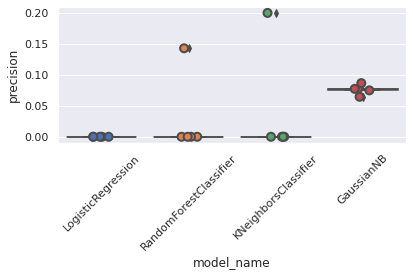

In [206]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score


from sklearn.model_selection import cross_val_score
models = [
    LogisticRegression(solver="liblinear", random_state=42),
    RandomForestClassifier(n_estimators=10, random_state=42),
    KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2),
    GaussianNB(),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, X, y, scoring='precision', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'precision'])

sns.boxplot(x='model_name', y='precision', data=cv_df)
sns.stripplot(x='model_name', y='precision', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()